In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import re, string
from nltk.corpus import stopwords
import gensim
from gensim.models import Word2Vec, KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import keras_core as keras
import keras_nlp
from transformers import BertTokenizer, BertForSequenceClassification
import keras
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using TensorFlow backend
/kaggle/input/bert/keras/bert_base_en_uncased/2/config.json
/kaggle/input/bert/keras/bert_base_en_uncased/2/tokenizer.json
/kaggle/input/bert/keras/bert_base_en_uncased/2/metadata.json
/kaggle/input/bert/keras/bert_base_en_uncased/2/model.weights.h5
/kaggle/input/bert/keras/bert_base_en_uncased/2/assets/tokenizer/vocabulary.txt
/kaggle/input/word2vec/GoogleNews-vectors-negative300.bin
/kaggle/input/word2vec-file/GoogleNews-vectors-negative300.bin
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# Introduction 

## Problem

This notebook tried to build a nlp model to identify whether a tweet is reporting a real disaster or not. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies). A precise model which can correctly label a tweet as 1(disaster) or 0(not disaster) could literally be a life saver. Since this task involoves anlysizing sequential data(tweets content), we will consider using RNN and pretrained Transformer to build our model.

## Data

The train data set for this problem has shape(7613, 5), including 5 columns: id, text, location, keyword, and target. At the same time, the test data set has shape(3263, 4), including id, text, location, and keyword.

# Exploratory Data Analysis (EDA)

## Load Data

In [2]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print('Training Set Shape = {}'.format(train.shape))
print('Test Set Shape = {}'.format(test.shape))


Training Set Shape = (7613, 5)
Test Set Shape = (3263, 4)


## Inspect and Explore Data

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
train[train['target'] == 1].loc[0]['text']

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [6]:
train[train['target'] == 0].loc[15]['text']

"What's up man?"

### Check Null Value

In [7]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

Only id and text columns have all values. We will build our model on anlysizing "text" column.

### Check Duplicate Value

In [9]:
train['text'].duplicated().sum()


110

There are 110 duplicated texts in the train set.

In [10]:
grouped = train.groupby('text')['target'].agg(['count', 'nunique'])
inconsistent_groups = grouped[grouped['nunique'] > 1]
if not inconsistent_groups.empty:
    print("Inconsistent groups found:")
    print(inconsistent_groups)
else:
    print("All duplicate texts have consistent targets.")

Inconsistent groups found:
                                                    count  nunique
text                                                              
#Allah describes piling up #wealth thinking it ...      3        2
#foodscare #offers2go #NestleIndia slips into l...      3        2
.POTUS #StrategicPatience is a strategy for #Ge...      4        2
CLEARED:incident with injury:I-495  inner loop ...      3        2
Caution: breathing may be hazardous to your hea...      2        2
He came to a land which was engulfed in tribal ...      6        2
Hellfire is surrounded by desires so be careful...      3        2
Hellfire! We donÛªt even want to think about i...      2        2
I Pledge Allegiance To The P.O.P.E. And The Bur...      2        2
In #islam saving a person is equal in reward to...      2        2
Mmmmmm I'm burning.... I'm burning buildings I'...      2        2
RT NotExplained: The only known image of infamo...      2        2
The Prophet (peace be upon him) sai

Saddly, there are some tweets that have same texts and different targets. These data will confuse our model, so we better clean them out.

In [11]:
# clear inconsistent data
train = train[~train['text'].isin(inconsistent_groups.index)]
# drop consistent duplicated data
train.drop_duplicates(subset='text', inplace=True)
# check duplicated text again
train['text'].duplicated().sum()


0

In [12]:
test.duplicated().sum()

0

## Clean Data

In [13]:
def clean(x):
    x = x.lower()
    x = re.sub(r"(@[A-Za-z0-9_]+)|(\w+:\/\/\S+)|[^a-zA-Z\s]", " ", x)
    x = x.translate(str.maketrans('', '', string.punctuation))
    stop_words = set(stopwords.words('english'))
    x = ' '.join([word for word in x.split() if word not in stop_words])
    return x

In [14]:
train['text'] = train['text'].apply(clean)

In [15]:
train['text'][0]

'deeds reason earthquake may allah forgive us'

### Check Data Distribution

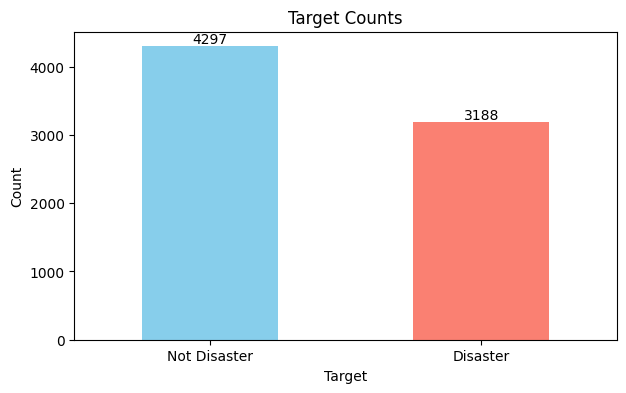

In [16]:
target_counts = train['target'].value_counts()

plt.figure(figsize=(7, 4))
bars=target_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Target Counts')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Disaster', 'Disaster'], rotation=0)
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2,  
             bar.get_height(),                  
             int(bar.get_height()),             
             ha='center',                       
             va='bottom')    
plt.show()

Our data is roughly balanced.

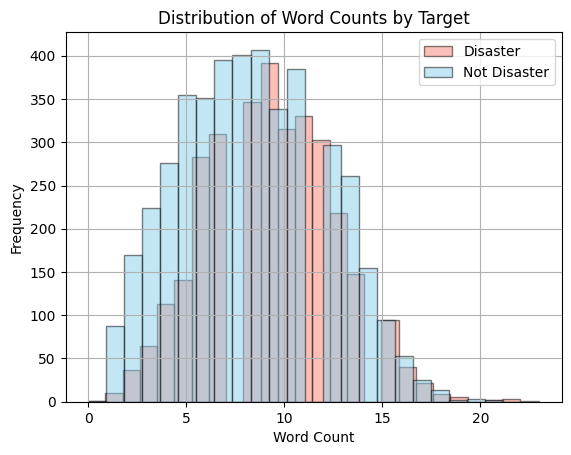

In [17]:
train['word_count'] = train['text'].apply(lambda x: len([word for word in x.split() if word]))

plt.hist(train[train['target'] == 1]['word_count'], bins=25, alpha=0.5, label='Disaster', color='salmon', edgecolor='black')
plt.hist(train[train['target'] == 0]['word_count'], bins=25, alpha=0.5, label='Not Disaster', color='skyblue', edgecolor='black')

plt.title('Distribution of Word Counts by Target')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.show()

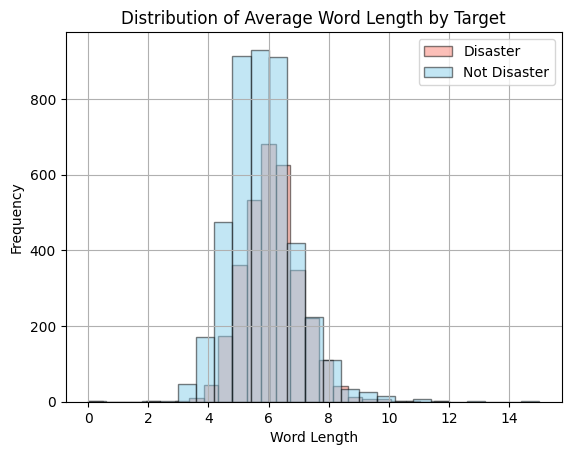

In [18]:
train['avg_word_len'] = train['text'].apply(lambda x: sum([len(word) for word in x.split()]) / len(x.split()) if len(x.split()) > 0 else 0)

plt.hist(train[train['target'] == 1]['avg_word_len'], bins=25, alpha=0.5, label='Disaster', color='salmon', edgecolor='black')
plt.hist(train[train['target'] == 0]['avg_word_len'], bins=25, alpha=0.5, label='Not Disaster', color='skyblue', edgecolor='black')

plt.title('Distribution of Average Word Length by Target')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.show()

The distributions of words count and average words length among disaster and not disaster data set are basically similar.

# Model Architecture

## Prepare Data(Word Embedding)

Before we build our model learn tweets texts, we need to convert text data to vector representation for efficiency and better performance. Here I choose to use **Word2Vec**

Word2Vec is a popular way to embed vocabulary as it can capture the similarity of words. Words used in similar contexts or having semantic relationships are captured effectively through their closeness in the vector space- effectively speaking similar words will have similar word vectors! For example, the context 1 is "I like orange juice." the context 2 is "I also like to drink apple juice". By learning above 2 contexts, word2vec model will realize the distance between "orange" and "apple" should be closer than "orange" and "human". As the result, the vector of "orange" will be similar with the vector of "apple"

For this perticular disaster tweet classification task, the words to help human identify if a tweet is about a real disaster usually are similar, like earthquaks, hurricane, fire.etc. Word2Vec can help our model to learn those synonymous words, then hopefully better detect if a tweet is reporting a disaster.

In [ ]:
# import gensim.downloader
# list(gensim.downloader.info()['models'].keys())

In [ ]:
# w2c = gensim.downloader.load('word2vec-google-news-300')


In [19]:
%%time
w2v_path = '/kaggle/input/word2vec/GoogleNews-vectors-negative300.bin' 
w2v_model = KeyedVectors.load_word2vec_format(w2v_path, binary=True)

CPU times: user 40.8 s, sys: 3.48 s, total: 44.3 s
Wall time: 1min 9s


In [20]:
w2v_model.most_similar("earthquake")


[('quake', 0.911206066608429),
 ('#.#_magnitude_earthquake', 0.8794152140617371),
 ('#.#_magnitude_quake', 0.8228378295898438),
 ('temblor', 0.8145468235015869),
 ('devastating_earthquake', 0.8075742721557617),
 ('earthquakes', 0.7766882181167603),
 ('quakes', 0.7350267767906189),
 ('aftershock', 0.733711838722229),
 ('magnitude_earthquake', 0.7275098562240601),
 ('Earthquake', 0.7246856689453125)]

In [21]:
%%time
texts = train['text'].astype(str).tolist()
targets = train['target'].tolist()

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

# Pad sequences to ensure uniform length
max_length = max(len(seq) for seq in sequences)
data = pad_sequences(sequences)

# Prepare Embedding Matrix
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in w2v_model:
        embedding_matrix[i] = w2v_model[word]


CPU times: user 401 ms, sys: 27.8 ms, total: 429 ms
Wall time: 428 ms


In [22]:
# check embedding matrix
print(embedding_matrix.shape)
data.shape


(13863, 300)


(7485, 23)

## Base Model

We first try a simple RNN model as a baseline. A base model can help us understand how RNN performances on this task. The simple base model will use long short term memory(LSTM). LSTM enables our model to remember longer context and hopefully learn a real disaster tweet context looks like better as well.

Architecture: embedding + LSTM(units=128, dropout=0.2, recurrent_dropout=0.2) + Dense(units=1, activation='sigmoid')

In [23]:
model = Sequential()
model.add(Input(shape = (data.shape[1],))),
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=data.shape[1], trainable=False))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 23, 300)        │     4,158,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       219,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,677 (16.70 MB)

 Trainable params: 219,777 (858.50 KB)

 Non-trainable params: 4,158,900 (15.86 MB)

In [24]:
%%time
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(data, np.array(targets), epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7234 - loss: 0.5577 - val_accuracy: 0.8156 - val_loss: 0.4227
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.8028 - loss: 0.4446 - val_accuracy: 0.8190 - val_loss: 0.4161
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8121 - loss: 0.4218 - val_accuracy: 0.8090 - val_loss: 0.4234
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8191 - loss: 0.4168 - val_accuracy: 0.8090 - val_loss: 0.4262
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8278 - loss: 0.3964 - val_accuracy: 0.8116 - val_loss: 0.4215
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8195 - loss: 0.3977 - val_accuracy: 0.8083 - val_loss: 0.4279
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8325 - loss: 0.3820 - val_accuracy: 0.8156 - val_loss: 0.4216
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8386 - loss: 0.3684 - val_accuracy: 0.8210 - v

In [25]:
def draw_learning_curve(history):
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
    loss, val_loss = history.history['loss'], history.history['val_loss']
   
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    plt.plot(acc, label="Train Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.ylim([min(plt.ylim()),1.])
    plt.title("Train and Validation Accuracy")
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.plot(loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.ylabel("Loss")
    plt.ylim([0,1.])
    plt.xlabel("Epochs")
    plt.title("Train and Validation Loss")
    plt.legend()

    plt.show()

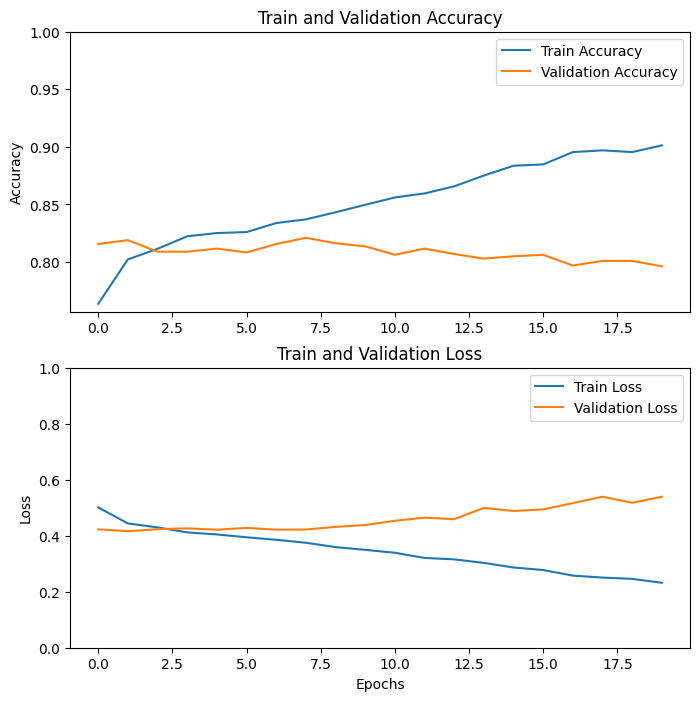

In [26]:
draw_learning_curve(history)

The base model performances good, achieved over 80% accuracy on both train set and validation set. Though the train accuracy keeps increasing with epoches while the validation accuracy starts to decrease with epoches, which is a sign of overfitting.

In [27]:
# store the performance of base model for later comparision
baseline_model = {'Name': 'Base Model', 
                  'Accuracy': history.history['accuracy'][-1],
                  'Val_Accuracy': history.history['val_accuracy'][-1],
                  'Loss': history.history['loss'][-1],
                  'Val_Loss': history.history['val_loss'][-1]}
model_results = [baseline_model]

In [28]:
model_results

[{'Name': 'Base Model',
  'Accuracy': 0.9013025760650635,
  'Val_Accuracy': 0.7962591648101807,
  'Loss': 0.2320205420255661,
  'Val_Loss': 0.5392749905586243}]

## Improve Base Model

Model 2 Let's try a more complex architecture. Bidirection + LSTM(units=256). To prevent overfitting, we also add l2 regularization.


In [31]:
model2 = Sequential()
model2.add(Input(shape = (data.shape[1],))),
model2.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=data.shape[1], trainable=False))
# model2.add(Bidirectional(LSTM(units=256, dropout=0.2, recurrent_dropout=0.2,return_sequences = True)))
model2.add(Bidirectional(LSTM(units=256, dropout=0.2, recurrent_dropout=0.2)))
model2.add(Dense(units=100, activation='relu', kernel_regularizer=l2(0.001)))
model2.add(Dense(units=1, activation='sigmoid', kernel_regularizer=l2(0.001)))
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 23, 300)        │     4,158,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 512)            │     1,140,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,351,037 (20.41 MB)

 Trainable params: 1,192,137 (4.55 MB)

 Non-trainable params: 4,158,900 (15.86 MB)

In [32]:
%%time
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history2 = model2.fit(
    data, 
    np.array(targets), 
    epochs=20, 
    batch_size=64, 
    validation_split=0.2, 
#     callbacks=[early_stopping]
)

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.7432 - loss: 0.6623 - val_accuracy: 0.8176 - val_loss: 0.4904
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8180 - loss: 0.4649 - val_accuracy: 0.8143 - val_loss: 0.4584
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8237 - loss: 0.4329 - val_accuracy: 0.8116 - val_loss: 0.4586
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8295 - loss: 0.4219 - val_accuracy: 0.8043 - val_loss: 0.4488
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8246 - loss: 0.4153 - val_accuracy: 0.8123 - val_loss: 0.4356
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8357 - loss: 0.3936 - val_accuracy: 0.7989 - val_loss: 0.4476
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8447 - loss: 0.3665 - val_accuracy: 0.8116 - val_loss: 0.4569
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.8469 - loss: 0.3620 - val_accuracy: 0.8110 - v

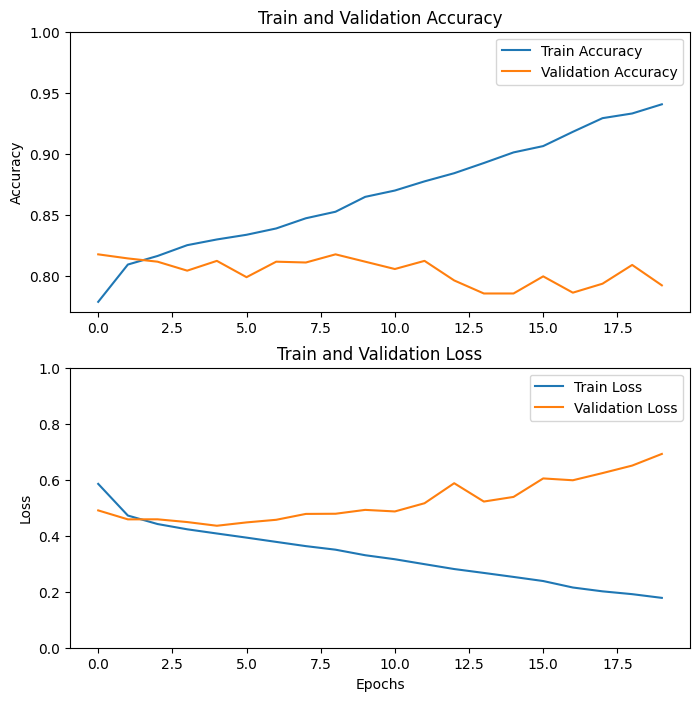

In [33]:
draw_learning_curve(history2)

In [34]:
model2_result = {'Name': 'Model With Bidirection And LSTM', 
                  'Accuracy': history2.history['accuracy'][-1],
                  'Val_Accuracy': history2.history['val_accuracy'][-1],
                  'Loss': history2.history['loss'][-1],
                  'Val_Loss': history2.history['val_loss'][-1]}
model_results.append(model2_result)


In [35]:
model_results

[{'Name': 'Base Model',
  'Accuracy': 0.9013025760650635,
  'Val_Accuracy': 0.7962591648101807,
  'Loss': 0.2320205420255661,
  'Val_Loss': 0.5392749905586243},
 {'Name': 'Model With Bidirection And LSTM',
  'Accuracy': 0.9405477643013,
  'Val_Accuracy': 0.7922511696815491,
  'Loss': 0.17805051803588867,
  'Val_Loss': 0.6921200752258301}]

Model 2 gains a better train accuracy, however the overfit issue becomes more seriously. Let's add batch norm and reduce complexity of the model, and see if it reduce overfitting. In model 3, we also enable early stopping so once our model starts overfit, it will stop in time.

In [39]:
model3 = Sequential()
model3.add(Input(shape = (data.shape[1],))),
model3.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=data.shape[1], trainable=False))
model3.add(Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2)))
# model3.add(Dense(units=100, activation='relu', kernel_regularizer=l2(0.001)))
# model3.add(Dropout(0.5)) 
model3.add(BatchNormalization())
model3.add(Dense(units=1, activation='sigmoid', kernel_regularizer=l2(0.001)))
model3.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 23, 300)        │     4,158,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 256)            │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,599,477 (17.55 MB)

 Trainable params: 440,065 (1.68 MB)

 Non-trainable params: 4,159,412 (15.87 MB)

In [40]:
%%time
model3.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history3 = model3.fit(
    data, 
    np.array(targets), 
    epochs=40, 
    batch_size=64, 
    validation_split=0.2, 
    callbacks=[early_stopping]
)

Epoch 1/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.7416 - loss: 0.5398 - val_accuracy: 0.7121 - val_loss: 0.6146
Epoch 2/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8082 - loss: 0.4410 - val_accuracy: 0.7448 - val_loss: 0.5721
Epoch 3/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8121 - loss: 0.4134 - val_accuracy: 0.8029 - val_loss: 0.5285
Epoch 4/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.8295 - loss: 0.3958 - val_accuracy: 0.8170 - val_loss: 0.4623
Epoch 5/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8396 - loss: 0.3768 - val_accuracy: 0.8036 - val_loss: 0.4464
Epoch 6/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8339 - loss: 0.3734 - val_accuracy: 0.8210 - val_loss: 0.4221
Epoch 7/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8579 - loss: 0.3391 - val_accuracy: 0.8036 - val_loss: 0.4433
Epoch 8/40
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8564 - loss: 0.3425 - val_accuracy: 0.8069 - v

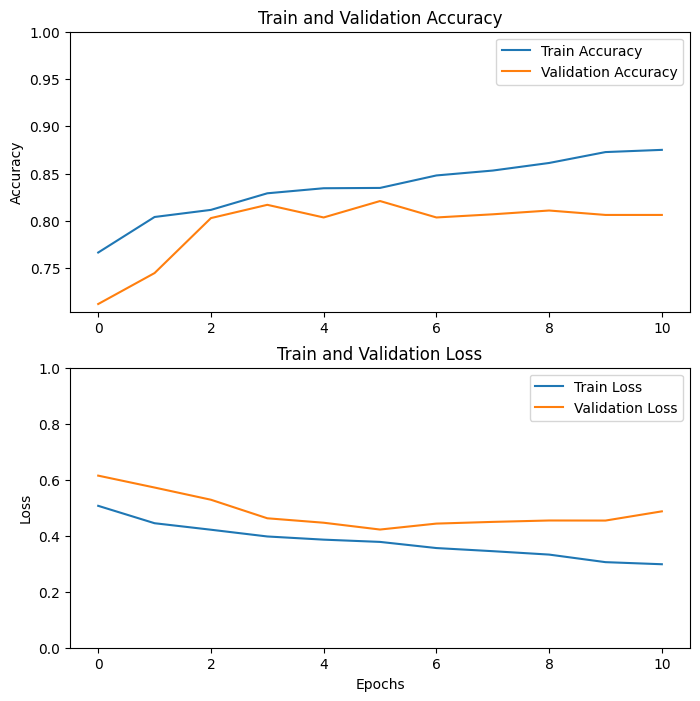

In [41]:
draw_learning_curve(history3)

In [42]:
model3_result = {'Name': 'Model With Bidirection, LSTM, And Batch Norm', 
                  'Accuracy': history3.history['accuracy'][-1],
                  'Val_Accuracy': history3.history['val_accuracy'][-1],
                  'Loss': history3.history['loss'][-1],
                  'Val_Loss': history3.history['val_loss'][-1]}
model_results.append(model3_result)

In [43]:
model_results

[{'Name': 'Base Model',
  'Accuracy': 0.9013025760650635,
  'Val_Accuracy': 0.7962591648101807,
  'Loss': 0.2320205420255661,
  'Val_Loss': 0.5392749905586243},
 {'Name': 'Model With Bidirection And LSTM',
  'Accuracy': 0.9405477643013,
  'Val_Accuracy': 0.7922511696815491,
  'Loss': 0.17805051803588867,
  'Val_Loss': 0.6921200752258301},
 {'Name': 'Model With Bidirection, LSTM, And Batch Norm',
  'Accuracy': 0.8750835061073303,
  'Val_Accuracy': 0.8062792420387268,
  'Loss': 0.2981478273868561,
  'Val_Loss': 0.48705998063087463}]

It looks better now. Since our dataset only contains over 7000 tweets, which is a relatively small dataset for a NLP problem. So our RNN model seems easily overfit.

In recent years, transformer seems to be more and more popular in NLP comminity. Unlike traditional RNN models, transformer is comprised of encoder and decoder and rely on self attension mechanism to learn, and it usually outperform than RNN models. Let's try transformer for this task!

For this task, I decided to use Keras pre-trained Bert model and fine tune it to get our model 4. Pre-trained BERT is easily use and usually works well.

In [45]:
X, y = train['text'], train['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
preset = "bert_base_en_uncased"

preprocessor = keras_nlp.models.BertPreprocessor.from_preset(
    preset=preset,
    sequence_length=160
)

classifier = keras_nlp.models.BertClassifier.from_preset(
    preset=preset,
    preprocessor=preprocessor,
    num_classes=2
)

classifier.summary()

Preprocessor: "bert_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                     │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ segment_ids (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bert_backbone (BertBackbone)  │ [(None, 768), (None,      │     109,482,240 │ padding_mask[0][0],        │
│                               │ None, 768)]               │                 │ segment_ids[0][0],         │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 768)               │               0 │ bert_backbone[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ classifier_dropout[0][0]   │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 109,483,778 (417.65 MB)

 Trainable params: 109,483,778 (417.65 MB)

 Non-trainable params: 0 (0.00 B)

Since BERT has very complex architecture, we will only run 2 epoches and use a very slow learning rate to prevent overfitting.

In [47]:
classifier.compile(
    loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-5),
    metrics=["accuracy"]
)

history4 = classifier.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=2,
    validation_data=(X_val, y_val),
    
)

Epoch 1/2


I0000 00:00:1727631790.028769     117 service.cc:145] XLA service 0x7a1195512480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727631790.028831     117 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727631790.028839     117 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1727631837.034880    1470 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_38140', 224 bytes spill stores, 224 bytes spill loads

I0000 00:00:1727631843.209741    1469 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_76', 1652 bytes spill stores, 1652 bytes spill loads

I0000 00:00:1727631889.149530     117 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_97', 48 bytes spill stores, 48 bytes spill loads
ptxas 

187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 826ms/step - accuracy: 0.6637 - loss: 0.5935

I0000 00:00:1727632087.684312    1538 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_38140', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1727632089.076160    1539 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_469', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1727632092.128569    1537 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_469', 968 bytes spill stores, 924 bytes spill loads

I0000 00:00:1727632097.747224    1540 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_493', 2024 bytes spill stores, 2016 bytes spill loads

I0000 00:00:1727632144.894176     115 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_78', 80 bytes spill stores, 80 bytes spill loads
ptxas warning : Regist

188/188 ━━━━━━━━━━━━━━━━━━━━ 408s 1s/step - accuracy: 0.6647 - loss: 0.5926 - val_accuracy: 0.8190 - val_loss: 0.4249
Epoch 2/2
188/188 ━━━━━━━━━━━━━━━━━━━━ 170s 903ms/step - accuracy: 0.8393 - loss: 0.3880 - val_accuracy: 0.8223 - val_loss: 0.4202


In [48]:
model4_result = {'Name': 'BERT Model', 
                  'Accuracy': history4.history['accuracy'][-1],
                  'Val_Accuracy': history4.history['val_accuracy'][-1],
                  'Loss': history4.history['loss'][-1],
                  'Val_Loss': history4.history['val_loss'][-1]}
model_results.append(model4_result)
model_results

[{'Name': 'Base Model',
  'Accuracy': 0.9013025760650635,
  'Val_Accuracy': 0.7962591648101807,
  'Loss': 0.2320205420255661,
  'Val_Loss': 0.5392749905586243},
 {'Name': 'Model With Bidirection And LSTM',
  'Accuracy': 0.9405477643013,
  'Val_Accuracy': 0.7922511696815491,
  'Loss': 0.17805051803588867,
  'Val_Loss': 0.6921200752258301},
 {'Name': 'Model With Bidirection, LSTM, And Batch Norm',
  'Accuracy': 0.8750835061073303,
  'Val_Accuracy': 0.8062792420387268,
  'Loss': 0.2981478273868561,
  'Val_Loss': 0.48705998063087463},
 {'Name': 'BERT Model',
  'Accuracy': 0.849532425403595,
  'Val_Accuracy': 0.822311282157898,
  'Loss': 0.36974281072616577,
  'Val_Loss': 0.4201822280883789}]

We can also see the confusion matrix of BERT model.

In [49]:
y_train_pred = classifier.predict(X_train)

188/188 ━━━━━━━━━━━━━━━━━━━━ 65s 329ms/step


In [50]:
def draw_confusion_matrix(y, y_pred):
    display = ConfusionMatrixDisplay.from_predictions(
        y,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster", "Disaster"],
        cmap=plt.cm.Blues
    )
    display.ax_.set_title("Confusion Matrix: Training Dataset")

    tn, fp, fn, tp = confusion_matrix(y_train, np.argmax(y_train_pred, axis=1)).ravel()
    f1_score = tp / (tp + (fp + fn) / 2)
    print("F1 score:", f1_score)

F1 score: 0.8652958455728074


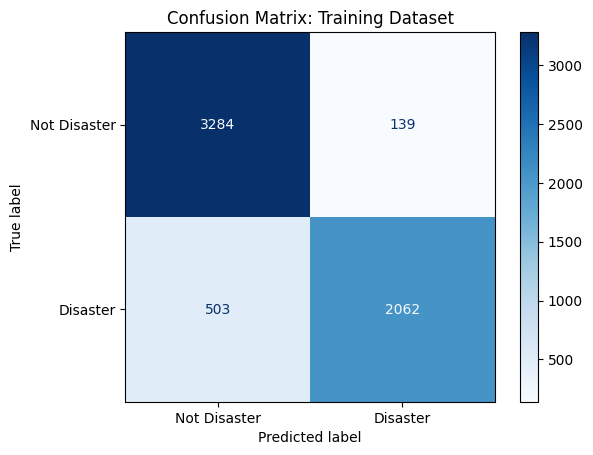

In [51]:
draw_confusion_matrix(y_train, y_train_pred)

47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 335ms/step
F1 score: 0.8652958455728074


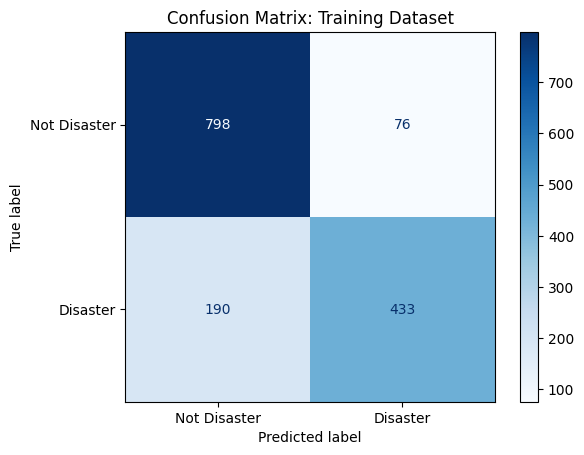

In [52]:
y_val_pred = classifier.predict(X_val)
draw_confusion_matrix(y_val, y_val_pred)

# Results and Analysis

## Model Results

In [53]:
results_df = pd.DataFrame(model_results)
results_df

,Name,Accuracy,Val_Accuracy,Loss,Val_Loss
0,Base Model,0.901303,0.796259,0.232021,0.539275
1,Model With Bidirection And LSTM,0.940548,0.792251,0.178051,0.692120
2,"Model With Bidirection, LSTM, And Batch Norm",0.875084,0.806279,0.298148,0.487060
3,BERT Model,0.849532,0.822311,0.369743,0.420182


## Analysis

* The First three models both used RNN architecture. 
* The base model indicates the baseline of RNN architecture performance on this particular task, and already manifests the sign of overfitting.
* The second model uses a more complex architecture, and indeed achieved a better train accuracy than baseline. However, a more complex model will make the overfit issue more seriously.
* The thrid model ultilizes batch normalization, reduce model complexity, and early stopping to pervent overfitting. Based on the learning curve line, it did help a bit.
* Lastly we tried fine tune BERT for our problem. It works the best!

In [ ]:
def submit(final_model):
    X_test = test['text'].apply(clean)
    sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
    sample_submission.head()

    sample_submission["target"] = np.argmax(final_model.predict(X_test), axis=1)

    sample_submission.to_csv("submission.csv", index=False)
    print("Your submission was successfully saved!")

In [ ]:
submit(classifier)

 # Conclusion

In this notebook, we used Word2Vec to vectorize our text, and tried different techniques to build models including LSTM, Bidireaction, and fine tune a pre-trained transformer model. We also utilized batch norm, l2 regularization, early stopping to prevent overfitting. RNN family and transformer both work well on this problem. In the future, if it's possible, gain more data will help our model performance a lot since our train dataset only contains over 7000 texts.

# Reference

* https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
* https://medium.com/@manansuri/a-dummys-guide-to-word2vec-456444f3c673
* https://en.wikipedia.org/wiki/Word2vec
* https://keras.io/guides/keras_nlp/getting_started/
* https://www.kaggle.com/code/josephtk/disaster-tweets-classification-using-bert
* https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-disaster-tweets
* https://www.kaggle.com/code/tuckerarrants/disaster-tweets-eda-glove-rnns-bert